# Overview :
This is an implementation of a deep neural network from scratch to classify images from the Fashion MNIST dataset as either "sneaker" (label 1) or "non-sneaker" (label 0).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split

# 1. Data Loading and Preprocessing


In [2]:
(train_images, train_labels), _ = fashion_mnist.load_data()


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

- train_images: Contains grayscale images of fashion items (shape: (60000, 28, 28)).
- train_labels: Contains labels for each image (values from 0 to 9).

### Creating a Binary Classification Dataset

In [4]:
sneaker_indices = np.where(train_labels == 7)[0] # extract Sneaker Images
non_sneaker_indices = np.where(train_labels != 7)[0] # extract non-Sneaker Images


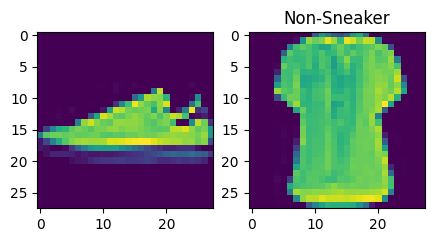

In [5]:
# Plotting the first sneaker image
plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
plt.imshow(train_images[sneaker_indices[0]])

# Plotting the first non-sneaker image
plt.subplot(1, 2, 2)
plt.imshow(train_images[non_sneaker_indices[50]])
plt.title('Non-Sneaker')

plt.show()

In [6]:
non_sneaker_sample_indices = np.random.choice(non_sneaker_indices, size=sneaker_indices.shape[0], replace=False)
balanced_indices = np.concatenate([sneaker_indices, non_sneaker_sample_indices])

# Balanced Dataset
X_balanced = train_images[balanced_indices]
y_balanced = train_labels[balanced_indices]
y_balanced = np.where(y_balanced == 7, 1, 0)


### Splitting into Training and Testing Sets

In [7]:
# Spliting dataset using sklearn
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced,
    y_balanced,
    test_size=0.2,
    random_state=42,
    stratify=y_balanced,
)


In [8]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9600, 28, 28), (2400, 28, 28), (9600,), (2400,))

In [9]:
train_x_flatten = X_train.reshape(X_train.shape[0], -1).T  # Shape: (784, 9600)
test_x_flatten = X_test.reshape(X_test.shape[0], -1).T     # Shape: (784, 2400)

train_x = train_x_flatten / 255.0
test_x = test_x_flatten / 255.0

y_train = y_train.reshape(1, -1)  # Shape: (1, 9600)
y_test = y_test.reshape(1, -1)    # Shape: (1, 2400)



In [13]:
train_x.shape, test_x.shape

((784, 9600), (784, 2400))

# 2. Parameter initialization

In [14]:
def initialize_parameters(layer_dims):
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):
        parameters["W" + str(l)] = (
            np.random.randn(layer_dims[l], layer_dims[l - 1]) * 0.01
        )
        parameters["b" + str(l)] = np.zeros((layer_dims[l], 1))

    return parameters


`layer_dims = [784, 5, 1]`
- `W1`: Weight matrix of shape (5, 784), small random values.
- `b1`: Bias vector of shape (5, 1), initialized to zeros.
- `W2`: Weight matrix of shape (1, 5), small random values.
- `b2`: Bias scalar, initialized to zero.

# 3. Model Creation

#### Linear forward step

In [ ]:
def linear_forward(A_prev, W, b):
    Z = W.dot(A_prev) + b
    cache = (A_prev, W, b)
    return Z, cache


- `A_prev`: Activations from the previous layer.
- `W`: Weights matrix.
- `b`: Bias vector.
- `Z`: Linear component before activation.


#### Activation Functions

In [ ]:
def relu(Z):
    A = np.maximum(0, Z)
    cache = Z
    return A, cache

def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    cache = Z
    return A, cache


In [ ]:
def linear_activation_forward(A_prev, W, b, activation):
    Z, linear_cache = linear_forward(A_prev, W, b)

    if activation == "relu":
        A, activation_cache = relu(Z)
    elif activation == "sigmoid":
        A, activation_cache = sigmoid(Z)

    cache = (linear_cache, activation_cache)

    return A, cache


#### Forward Propagation through layers

In [ ]:
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2

    # Hidden layers with ReLU activation
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(
            A_prev, parameters["W" + str(l)], parameters["b" + str(l)], "relu"
        )
        caches.append(cache)

    # Output layer with Sigmoid activation
    AL, cache = linear_activation_forward(
        A, parameters["W" + str(L)], parameters["b" + str(L)], "sigmoid"
    )
    caches.append(cache)

    return AL, caches

Simulation for NN with `[784, 5, 1]` layout:
- Input `X`: Shape `(784, m)` where `m` is the number of examples.
We take one example `(m = 1)` for simplicity.

- Layer 1 :
  - `A_prev(X)`: `Shape (784, 1)`.
  - `W1`: `Shape (5, 784)`.
  - `b1`: `Shape (5, 1)`.
  - Compute `Z1` = `W1.dot(A_prev) + b1: Shape (5, 1)`.
  - Apply ReLU: `A1 = relu(Z1): Shape (5, 1)`.

- Layer 2:

  - `A_prev(A1): Shape (5, 1)`.
  - `W2: Shape (1, 5`).
  - `b2: Scalar`.
  - `Compute Z2 = W2.dot(A1) + b2: Shape (1, 1)`.
  - Apply Sigmoid: `AL = sigmoid(Z2): Shape (1, 1)`.


### Calculate Cost

In [ ]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = (
        -1
        / m
        * np.sum(
            np.multiply(Y, np.log(AL)) + np.multiply(1 - Y, np.log(1 - AL))
        )
    )
    cost = np.squeeze(cost)
    return cost


- Suppose `AL = [[0.8]]` (model's prediction).
- True label `Y = [[1]]`.

  ```
  cost = - (1/m) * [Y * log(AL) + (1 - Y) * log(1 - AL)]
       = - [1 * log(0.8) + 0 * log(0.2)]
       = - log(0.8)
       ≈ 0.223
  ```


### Backward Propagation

### Activation Function Backward

#### Linear Activation backward

## 4. Model Training

## 5. Model Evaluation